## Installing and importing libraries

In [ ]:
import math
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from numba import jit

# Pre-Processing

In [ ]:
# Clean data
def parser(series):
    series = series.strip()

    if series.startswith("[") and series.endswith("]"):
        series = series[1:-1]

    return list(map(float, series.split(",")))

Here we define a function named "parser", which processes a string representation of a numerical list and converts it into an actual Python list of floating-point numbers. The function first removes any leading or trailing whitespace from the string. If the string begins or ends with brackets, it strips off those too. After cleaning the string, it splits the remaining content by commas into individual components. Finally, it applies the float function to each component, to convert the substrings into floating-point numbers, and wraps the result into a Python list.

## Dynamic Time Warping algorithm

In [ ]:
@jit(nopython=True)
def dtw_distance(series_a, series_b, r):

    n = len(series_a)
    m = len(series_b)

    # Create and fill a cost matrix with infinity
    D = np.full((n+1, m+1), np.inf)
    D[0, 0] = 0

    # Populate the cost matrix with series costs
    # Sakoe-Chiba Band constraint is used (r)
    for i in range(1, n+1):
        for j in range(max(1, i - r), min(m + 1, i + r + 1)):

            cost = abs(series_a[i-1] - series_b[j-1])

            D[i, j] = cost + min(
                D[i-1, j],    # insertion
                D[i, j-1],    # deletion
                D[i-1, j-1]   # match
            )

    return D[n, m]

Here we implement the Dynamic Time Warping algorithm with Sakoe-Chiba Band constraint to compute the minimum alignment cost between two time series, with a given bandwidth r. The function initializes a cost matrix D with dimensions (n+1) x (m+1) (where n and m are the lengths of the two sequences) and fills it with `inf`, except for D[0, 0], which is set to 0 as the starting point. Using nested loops constrained by the Sakoe-Chiba Band(for optimized computation time), the local alignment cost for valid cells is calculated, and the matrix is updated with the relation to compute the cumulative cost. The local alignment cost is calculated using the L2 norm (Euclidean distance) and since the data are one-dimensional we use the absolute values ensuring a more accurate similarity measure with less computational cost.Finally, the function returns the total DTW distance, which is the value in the bottom-right corner of the matrix (D[n, m]), representing the optimal alignment cost between the sequences under the constraints. This function is optimized for numerical computation using Numba’s @jit decorator for faster execution bypassing the Python interpreter and compiling the code as machine code.

# MAIN PROCESS

In [ ]:
df = pd.read_csv("/kaggle/input/dtw-test/dtw_test.csv")

# Sakoe-Chiba Band
band_width = 250

distances = []
start_time = time.time()

for idx, row in df.iterrows():

    # Parse data
    series_a = parser(row["series_a"])
    series_b = parser(row["series_b"])

    # Compute DTW distance with Sakoe-Chiba restriction
    distance = dtw_distance(series_a, series_b, band_width)

    distances.append(distance)

end_time = time.time()
total_time = end_time - start_time

print(f"Computed DTW distances for {len(df)} pairs of time series.")
print(f"Total execution time: {total_time:.4f} seconds")

Computed DTW distances for 1002 pairs of time series.
Total execution time: 4.5582 seconds


Here I compute the DTW distances between pairs of time series stored in the dataset, with a Sakoe-Chiba Band constraint to limit the alignment path. The constraint limits the range of indices for computing more efficiently the distance between series. The CSV has three columns: id, series_a, and series_b, where each row represents a pair of time series to compare. For each row, the series_a and series_b strings are parsed into numerical lists using the parser function. The dtw_distance function is then called to calculate the DTW distance between the two series, constrained by the specified band_width (250), which restricts alignment to within 250 steps of the diagonal. The distances are stored in a list, and the total computation time is measured and printed along with the number of pairs processed.

        ID DTW Distance
0        0          inf
1        1          inf
2        2          inf
3        3          inf
4        4          inf
...    ...          ...
997    997          inf
998    998          inf
999    999          inf
1000  1000          inf
1001  1001          inf

[1002 rows x 2 columns]


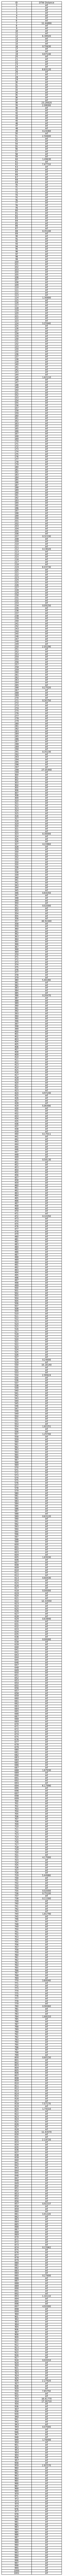

In [ ]:
# Create a DataFrame with the id and computed DTW distances
df["id"] = df["id"].astype(str)
distances = [f"{dist:.5f}" for dist in distances]

results_df = pd.DataFrame({
    "ID": df["id"],
    "DTW Distance": distances
})

print(results_df)

# Plot the table
fig, ax = plt.subplots(figsize=(5, 6))
ax.axis('tight')
ax.axis('off')

table = ax.table(
    cellText=results_df.values,
    colLabels=results_df.columns,
    cellLoc='center',
    loc='center'
)

plt.show()

This code creates and displays a table showing IDs and their DTW distances. First, it ensures the id column of the DataFrame is converted to strings for proper display. The distances list, which contains the computed DTW distances, is then formatted to five decimal places. A new data frame is created with two columns: ID (containing string IDs) and DTW Distance (containing the formatted distances). The table is then plotted using Matplotlib, where ax.table() generates a table visualization.

The `inf` values in the DTW distances show us that the cost matrix (D) is not being correctly populated for many of the time series. This is probably because the Sakoe-Chiba band is too restrictive. If the constraint is too tight, there may not be enough overlap between the time series, resulting in `inf` values in the cost matrix. When the best warping path between two series falls outside this band, the algorithm never updates the necessary cells and the final DTW distance remains infinite.

In [ ]:
df = pd.read_csv("/kaggle/input/dtw-test/dtw_test.csv")

# Sakoe-Chiba Band
band_width = 300

distances = []
start_time = time.time()

for idx, row in df.iterrows():

    # Parse data
    series_a = parser(row["series_a"])
    series_b = parser(row["series_b"])

    # Compute DTW distance with Sakoe-Chiba restriction
    distance = dtw_distance(series_a, series_b, band_width)

    distances.append(distance)

end_time = time.time()
total_time = end_time - start_time

print(f"Computed DTW distances for {len(df)} pairs of time series.")
print(f"Total execution time: {total_time:.4f} seconds")

Computed DTW distances for 1002 pairs of time series.
Total execution time: 3.4293 seconds


Here I compute, the DTW distances for band_width=300, again to see if I can calculate the series with the `inf` value that had the best warping path outside of the constraint band.

# PLOT

        ID DTW Distance
0        0     18.87520
1        1     16.43970
2        2     12.07230
3        3     17.01500
4        4      8.73690
...    ...          ...
997    997     14.43140
998    998      5.44700
999    999      0.72738
1000  1000      2.23710
1001  1001      2.13640

[1002 rows x 2 columns]


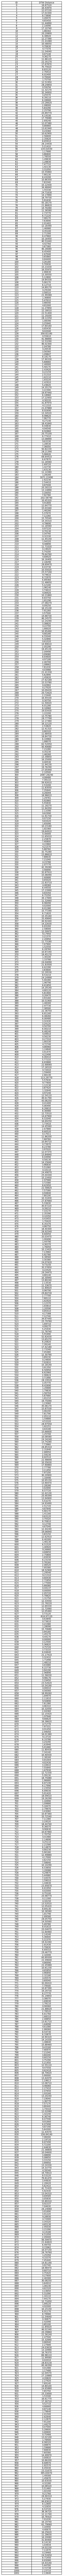

In [ ]:
# Create a DataFrame with the id and computed DTW distances
df["id"] = df["id"].astype(str)
distances = [f"{dist:.5f}" for dist in distances]

results_df = pd.DataFrame({
    "ID": df["id"],
    "DTW Distance": distances
})

print(results_df)

# Plot the table
fig, ax = plt.subplots(figsize=(5, 6))
ax.axis('tight')
ax.axis('off')

table = ax.table(
    cellText=results_df.values,
    colLabels=results_df.columns,
    cellLoc='center',
    loc='center'
)

plt.show()

results_df.to_csv("dtw.csv", index=False)

By increasing the Sakoe-Chiba band_width=300, the DTW algorithm computes distances correctly between the time series. With a smaller band, many alignments were constrained too tightly, resulting in `inf` value distances when the optimal warping path fell outside the restricted region. With the wider bandwidth, the warping paths can adjust to the variations of the data and calculate DTW distances that show the accurate similarity between the series. Also saves the results to dtw.csv.